In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random as random_sparse

In [2]:
# implementing l1 procrustes loss with irls/weighted majorization
# from https://link.springer.com/chapter/10.1007%2F3-540-27373-5_18

# Finding T which minimizes sum i,j abs(e_i,j), where E = Y - XT
# init T = I
def l1proc_min(X, Y, num_iters):
    n, k = X.shape
    T_0 = np.identity(k)
    err = np.zeros((num_iters))
    
    for curr_it in range(num_iters):
        E_0 = (Y - X.dot(T_0)) # + np.random.normal(loc=.001, scale=.01, size=(Y.shape))
        if np.any(E_0 == 0):
            print('0 err on iter ' + str(curr_it) + '! Stopping')
            return T, err
        W = 1 / np.abs(E_0) 
    
        err[curr_it] = np.abs(E_0).sum()
    
        D_m = np.diag(W.max(axis=1))   
#         infloc = np.where(D_m == np.inf)  # replacing 0 error terms with max of non-inf nums
#         tmp = np.copy(D_m)
#         tmp[tmp == np.inf] = 0
#         D_m[infloc] = np.min(tmp)
        
        weight = np.divide(W, W.max(axis=1).reshape((n,1)))
        weight[np.isnan(weight)] = 0
        R = np.multiply((1 - weight), X.dot(T_0)) + np.multiply(weight, Y)
        
        S = np.dot(np.dot(np.transpose(X), D_m), R)
        U, sig, V_T = np.linalg.svd(S)
        T = U.dot(V_T)
        E = Y - X.dot(T)
#         T[:, infloc[1]] = T_0[:, infloc[1]]
#         if np.shape(infloc)[1] > 0:
#             print(T - T_true)
        T_0 = T

    return T, err

# Orthogonal procrustes l2
def l2proc_min(X, Y):
    M = X.T.dot(Y)
    U, S, V_T = np.linalg.svd(M)
    T = U.dot(V_T)
    return T

0 err on iter 69! Stopping


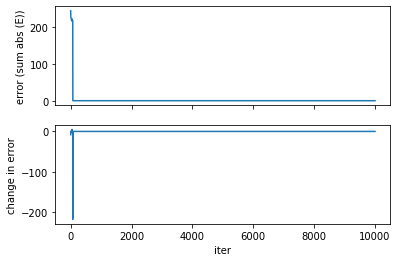

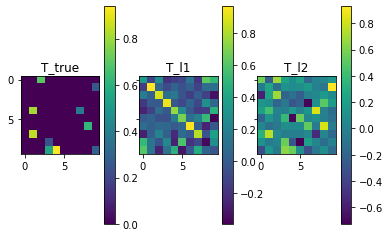

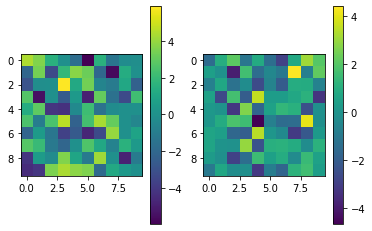

218.06224989495652 135.8579412371496


In [3]:
# Testing with a sparse T
n, k = 10, 10

X = np.random.uniform(-5, 5, size=(n, k))
sparse = random_sparse(k, k, density=1/k)
# T_true, R = np.linalg.qr(sparse.A)  # make T_true orthogonal
T_true = sparse.A
Y = X.dot(T_true)

T_l1, err = l1proc_min(X, Y, num_iters=10000)
E_l1 = Y - X.dot(T_l1)

T_l2 = l2proc_min(X, Y)
E_l2 = Y - X.dot(T_l2)

# plotting
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(err)
ax[0].set(ylabel='error (sum abs (E))')
ax[1].plot(err[1:] - err[:-1])
ax[1].set(xlabel='iter', ylabel='change in error')

fig, ax = plt.subplots(1, 3, sharey=True)
im = ax[0].imshow(T_true)
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow(T_l1)
fig.colorbar(im, ax=ax[1])
im = ax[2].imshow(T_l2)
fig.colorbar(im, ax=ax[2])
ax[0].set(title='T_true')
ax[1].set(title='T_l1')
ax[2].set(title='T_l2')

fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(E_l1)
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow(E_l2)
fig.colorbar(im, ax=ax[1])
plt.show()

print(np.abs(E_l1).sum(), np.abs(E_l2).sum())